warnings: <br>
1. pillow 5.2.0 is the only version that loads the tiff files correctly! <br>
2. For nn.Identity() to work, you need pytorch > 1.0.0 (not sure by how much). However, with 1.3.1 fastai stops working well. 

In [1]:
# check for OS and set params accordingly. 
import platform
machine_OS = platform.system()
if machine_OS == 'Windows':
    batch_size = 1 
    num_workers = 0
elif machine_OS == 'Linux':
    batch_size = 1 
    num_workers = 16 
print(machine_OS, 'OS. Batchsize:', batch_size, ', Num of workers:', num_workers)

# set cuda engine and get debugging information
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' 

# import packages:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import os
from tqdm import tqdm_notebook
# import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim 
import torchvision
from torchvision import models
from torch.utils.data import DataLoader, Dataset
import torch.utils.data as utils

from torchvision import transforms

import torch.nn.functional as F

from IPython.display import display
from pathlib import Path


from torchsummary import summary
from m_network_architectures import *

Windows OS. Batchsize: 1 , Num of workers: 0


# Getting the data

## if data needs to be downloaded

In [80]:
BaseFolder = Path.cwd()
DataFolder = BaseFolder/'Data'
DataFolder.mkdir(parents=True, exist_ok=True)
DataFolder

WindowsPath('C:/Users/M/RetinaChlng/Data')

In [3]:
DataFolder.as_posix()

'C:/Users/M/RetinaChlng/Data'

The data is on https://drive.grand-challenge.org/Download/. First you need to sign in and join. 
Then, in Chrome "More tools", go to "developer mode". Click on the link in the regular webpage. In the developer mode pane, right click on the file, and select copy cURL (bash). 

in cmd:
$ wsl \{whatever is copied\} -O -J
The -O to keep remote filenme.
The -J to preserve headers. 

PROBLEM! will save in current directory. Try 
(cd TARGET_DIRECTORY && curl ...) which will only work for linux. In windows, the wsl has problmes with the folder names and this think would not work!

In [32]:
! wsl curl 'https://grand-challenge.org/media/drive/datasets/training.zip' -H 'authority: grand-challenge.org' -H 'upgrade-insecure-requests: 1' -H 'dnt: 1' -H 'user-agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.108 Safari/537.36' -H 'sec-fetch-user: ?1' -H 'accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3' -H 'sec-fetch-site: same-site' -H 'sec-fetch-mode: navigate' -H 'referer: https://drive.grand-challenge.org/Download/' -H 'accept-encoding: gzip, deflate, br' -H 'accept-language: en-US,en;q=0.9,he;q=0.8' -H 'cookie: _ga=GA1.2.1565214317.1576505279; _gid=GA1.2.953096119.1576505279; csrftoken=DndYhrBm0rFslO4XYaF491J4s4KmW4NL4YeRaqEj5b9MOTG9TwzxvBiP8LECxJdc; sessionid=y0mfptew573i5wdm45bvi6j9f7t6vfz0' --compressed -O -J
! wsl curl 'https://grand-challenge.org/media/drive/datasets/test.zip' -H 'authority: grand-challenge.org' -H 'upgrade-insecure-requests: 1' -H 'dnt: 1' -H 'user-agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.108 Safari/537.36' -H 'sec-fetch-user: ?1' -H 'accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3' -H 'sec-fetch-site: same-site' -H 'sec-fetch-mode: navigate' -H 'referer: https://drive.grand-challenge.org/Download/' -H 'accept-encoding: gzip, deflate, br' -H 'accept-language: en-US,en;q=0.9,he;q=0.8' -H 'cookie: _ga=GA1.2.1565214317.1576505279; _gid=GA1.2.953096119.1576505279; csrftoken=DndYhrBm0rFslO4XYaF491J4s4KmW4NL4YeRaqEj5b9MOTG9TwzxvBiP8LECxJdc; sessionid=y0mfptew573i5wdm45bvi6j9f7t6vfz0' --compressed -O -J

curl: Saved to filename 'training.zip'


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  1 14.0M    1  175k    0     0   187k      0  0:01:16 --:--:--  0:01:16  187k
 93 14.0M   93 13.1M    0     0  7086k      0  0:00:02  0:00:01  0:00:01 13.4M
100 14.0M  100 14.0M    0     0  7486k      0  0:00:01  0:00:01 --:--:-- 14.0M


curl: Saved to filename 'test.zip'


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  1 13.8M    1  192k    0     0   212k      0  0:01:07 --:--:--  0:01:07  212k
100 13.8M  100 13.8M    0     0  7883k      0  0:00:01  0:00:01 --:--:-- 7883k


In [ ]:
## For Linux:
# ! (cd {DataFolder.as_posix()} && curl 'https://grand-challenge.org/media/drive/datasets/training.zip' -H 'authority: grand-challenge.org' -H 'upgrade-insecure-requests: 1' -H 'dnt: 1' -H 'user-agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.108 Safari/537.36' -H 'sec-fetch-user: ?1' -H 'accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3' -H 'sec-fetch-site: same-site' -H 'sec-fetch-mode: navigate' -H 'referer: https://drive.grand-challenge.org/Download/' -H 'accept-encoding: gzip, deflate, br' -H 'accept-language: en-US,en;q=0.9,he;q=0.8' -H 'cookie: _ga=GA1.2.1565214317.1576505279; _gid=GA1.2.953096119.1576505279; csrftoken=DndYhrBm0rFslO4XYaF491J4s4KmW4NL4YeRaqEj5b9MOTG9TwzxvBiP8LECxJdc; sessionid=y0mfptew573i5wdm45bvi6j9f7t6vfz0' --compressed -O -J)
# ! (cd {DataFolder.as_posix()} && curl 'https://grand-challenge.org/media/drive/datasets/test.zip' -H 'authority: grand-challenge.org' -H 'upgrade-insecure-requests: 1' -H 'dnt: 1' -H 'user-agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.108 Safari/537.36' -H 'sec-fetch-user: ?1' -H 'accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3' -H 'sec-fetch-site: same-site' -H 'sec-fetch-mode: navigate' -H 'referer: https://drive.grand-challenge.org/Download/' -H 'accept-encoding: gzip, deflate, br' -H 'accept-language: en-US,en;q=0.9,he;q=0.8' -H 'cookie: _ga=GA1.2.1565214317.1576505279; _gid=GA1.2.953096119.1576505279; csrftoken=DndYhrBm0rFslO4XYaF491J4s4KmW4NL4YeRaqEj5b9MOTG9TwzxvBiP8LECxJdc; sessionid=y0mfptew573i5wdm45bvi6j9f7t6vfz0' --compressed -O -J)

In [3]:
## For Linux:
# if not previously installed:
# ! sudo apt-get install p7zip-full
! 7z x {DataFolder}/*.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,8 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /home/jupyter/RetinaProject/Data                                          1 file, 14571523 bytes (14 MiB)

Extracting archive: /home/jupyter/RetinaProject/Data/test.zip
--
Path = /home/jupyter/RetinaProject/Data/test.zip
Type = zip
Physical Size = 14571523


No files to process
Everything is Ok

Files: 0
Size:       0
Compressed: 14571523


# data loading

In [6]:
BaseFolder = Path.cwd()
DataFolder = BaseFolder/'Data'

x_train_dir = DataFolder/'training'/'images'
y_train_dir = DataFolder/'training'/'1st_manual'
screen_train_dir = DataFolder/'training'/'mask'

# x_test_dir = os.path.join(DATA_DIR, 'test')
# y_test_dir = os.path.join(DATA_DIR, 'testannot')

# Custum dataloader

In [2]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

## Making a Map-style dataset

In [3]:
from m_dataset_aux_functions import *

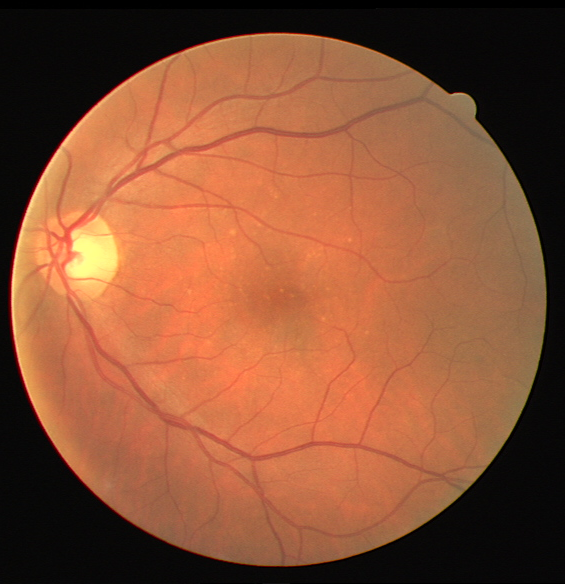

In [7]:
images_dir = x_train_dir
x_images_paths = [str(image_path.absolute()) for image_path in images_dir.glob('*.tif')]
im = Image.open(x_images_paths[0])
display(im)

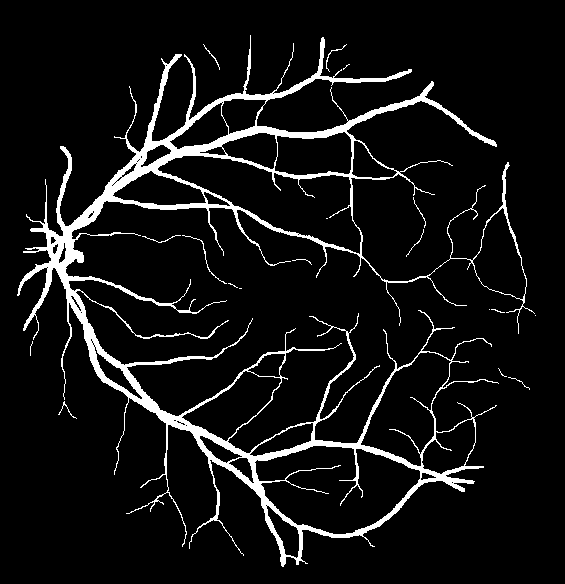

In [85]:
images_dir = x_train_dir
masks_dir = y_train_dir
x_images_paths = [str(image_path.absolute()) for image_path in images_dir.glob('*.tif')]
y_masks_paths = [str(get_mask_path(image_path, masks_dir).absolute()) for 
                         image_path in images_dir.glob('*.tif')]
im = Image.open(y_masks_paths[0])
display(im)
tmp_im = np.array(im)

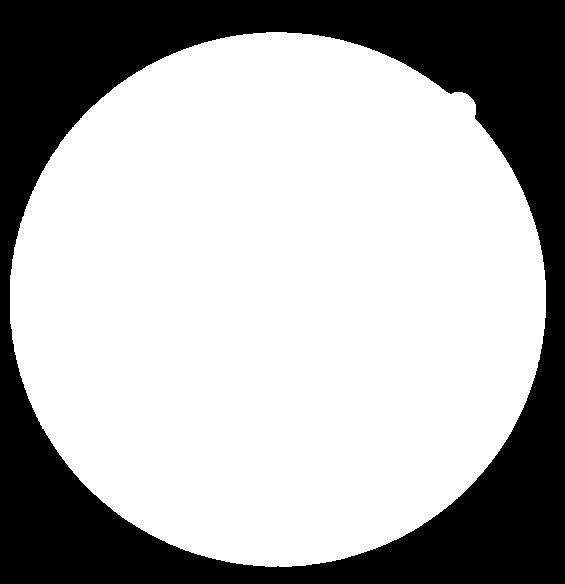

In [86]:
images_dir = x_train_dir
x_images_paths = [str(image_path.absolute()) for image_path in images_dir.glob('*.tif')]
tmp_path = get_screen_path(Path(x_images_paths[0]), screen_train_dir)
im_mask =  Image.open(str(tmp_path))
display(im_mask)

In [6]:
from m_dataset_aux_functions import *

In [8]:
interpolation = 2 # only valid if image size is defined. 
ImageSize = None # makes the image a square. None will maintain the original size
MaxTrainingSetSize = 1
(trainDataset, vldtnDataset) = MakeDatasets(x_train_dir, screen_train_dir, y_train_dir, 
                                            MaxTrainingSetSize = MaxTrainingSetSize, size = ImageSize, interpolation = interpolation)
print('Training set size: {}, Validation set size: {}'.format(len(trainDataset), len(vldtnDataset)))

Training set size: 1, Validation set size: 1


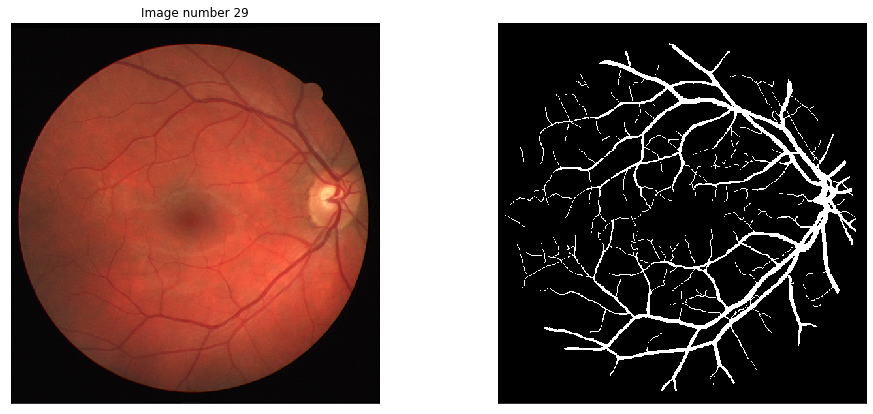

In [9]:
visualizeDataset(trainDataset)

# Create model and train

In [10]:
from m_network_architectures import *
from m_dataset_aux_functions import *

In [11]:
train_loader = DataLoader(dataset = trainDataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
vldtn_loader = DataLoader(dataset = vldtnDataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [93]:
del model
torch.cuda.empty_cache()
import gc
gc.collect()

6749

In [17]:
with torch.no_grad():
    output = torch.tensor(np.random.random(5000), requires_grad = True)
    target = torch.tensor(np.random.randint(0,2,5000), requires_grad = False)
    del m_loss_functionals
    import m_loss_functionals
    criterion = m_loss_functionals.FocalLoss()
    loss = criterion(output, target, alpha = torch.tensor(.2), gamma = 2.)
    print(loss)
    del loss

NameError: name 'm_loss_functionals' is not defined

In [19]:
del m_loss_functionals
import m_loss_functionals
criterion = m_loss_functionals.FocalLoss()
loss = criterion(output, target, screen, alpha = torch.tensor(1.), gamma = 2.)

NameError: name 'output' is not defined

In [12]:
import m_loss_functionals
# model = UNet(n_class=1).cuda()
# model = UNet_V2(n_class=1).cuda()
model = UNet_V3(n_class=1).cuda()

# criterion = nn.BCEWithLogitsLoss(torch.tensor(20))
criterion = m_loss_functionals.DiceLoss()
# criterion = m_loss_functionals.FocalLoss()
# criterion = m_loss_functionals.WCE()

# criterion = nn.CrossEntropyLoss()

In [18]:
# model = torch.load(str(BaseFolder / 'Model640Intrpl_dice_1bs_50Epochs.pth'))

In [13]:
lr_SGD_Dice = 1e-1 # for batch_size = 1, image_size = 224
lr_SGD_Dice = 0.1 # 0.1 for batch_size = 1, image_size = 608 works no interpolation in Unet2, ADAM 0.1 # done
lr_SGD_Dice = 0.1 # 0.1 for batch_size = 1, original size, no interpolation in Unet2, ADAM 0.1 # done. Sometimes works. 
lr_SGD_Dice = 0.1 # 0.1 for batch_size = 1, interpolation = 2, ImageSize = 608, Unet2, SGD 0.1 # done. Works super fast. 
# lr_SGD_Dice = 0.1 # 0.1 for batch_size = 2, original size, no interpolation in Unet2, ADAM 0.1 ### done. Sometimes works. 
# lr_SGD_Dice = 0.15 # 0.1f for batch_size = 1, original size, no interpolation in Unet2, ADAM 0.1 # FAIL
# check size 
lr_SGD_Dice = 5e-2
lr = lr_SGD_Dice
optimizer = torch.optim.SGD(model.parameters(), weight_decay=1e-4, lr = lr, momentum=0.9) # works well
# optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4, lr = lr)
losses = list()
vldtn_losses = list()
model.train()
for epoch in range(50): 
    t0 = time.time()
    Epoch_losses = list()
    model.train()         
    for ii, (data, target, screen) in enumerate(train_loader):    
        data, target, screen = data.cuda(), target.cuda(), screen.cuda() # please do so before constructing optimizers for it
        # maybe the screen needs not to be uploaded to cuda
        # data.requires_grad_()
        optimizer.zero_grad()
        output = model(data)  
        # loss = criterion(output, target) # for BCE loss.
#         loss = criterion(output, target, screen, alpha = torch.tensor(1.), gamma = 2.)
        loss = criterion(output, target, screen)
#         loss = criterion(output, target, screen)

        loss.backward()
        optimizer.step()
        Epoch_losses.append(loss.item())
        del loss
    losses.append(np.mean(Epoch_losses))
    # run validation
    with torch.no_grad():
        model.eval()
        val_Epoch_losses = list()
        for ii, (data, target, screen) in enumerate(vldtn_loader): 
            data, target, screen = data.cuda(), target.cuda(), screen.cuda()
            output = model(data) 
#             val_loss = diceLoss(output, target)
            val_loss = criterion(output, target, screen)
#             val_loss = criterion(output, target, screen, alpha = torch.tensor(1.), gamma = 2.)
            val_Epoch_losses.append(val_loss.item()) 
            del val_loss
    vldtn_losses.append(np.mean(val_Epoch_losses))
    
    adjust_learning_rate(lr, optimizer, epoch, ratio = 0.5, epochNumForDecrease = 25)
    print('Epoch: {} - Loss: {:.4f} , Validation: {:.4f}, Runtime: {:.2f} [s]'.format(epoch + 1, 
                                                                              np.mean(Epoch_losses),
                                                                              np.mean(val_Epoch_losses),
                                                                              time.time()- t0))

New learning rate:  0.05
Epoch: 1 - Loss: 0.7909 , Validation: 0.7956, Runtime: 2.73 [s]
Epoch: 2 - Loss: 0.7800 , Validation: 0.7941, Runtime: 1.48 [s]


RuntimeError: CUDA out of memory. Tried to allocate 242.00 MiB (GPU 0; 4.00 GiB total capacity; 2.48 GiB already allocated; 128.47 MiB free; 369.19 MiB cached)

In [2]:
from torchsummary import summary
from m_network_architectures import *

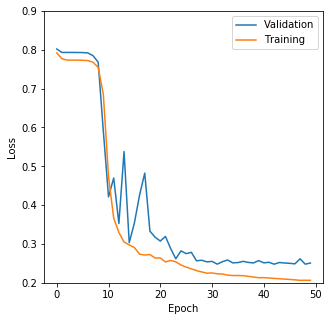

In [19]:
fig, ax = plt.subplots(1, figsize = (5,5))
ax.plot(vldtn_losses, label = 'Validation')
ax.plot(losses, label = 'Training')
ax.legend();
ax.set(xlabel = 'Epoch', ylabel = 'Loss', ylim = [0.2,0.9]);

In [22]:
interpolation = 0  # only valid if image size is defined. 
ImageSize = None # makes the image a square. None will maintain the original size
MaxTrainingSetSize = 16
(trainDataset, vldtnDataset) = MakeDatasets(x_train_dir, screen_train_dir, y_train_dir, 
                                            MaxTrainingSetSize = MaxTrainingSetSize, size = ImageSize, interpolation = interpolation)
print('Training set size: {}, Validation set size: {}'.format(len(trainDataset), len(vldtnDataset)))

Training set size: 16, Validation set size: 4


In [23]:
train_loader = DataLoader(dataset = trainDataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
vldtn_loader = DataLoader(dataset = vldtnDataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [24]:
lr_SGD_Dice = 1e-1 # for batch_size = 1, image_size = 224
lr_SGD_Dice = 0.1 # 0.1 for batch_size = 1, image_size = 608 works no interpolation in Unet2, ADAM 0.1 # done
lr_SGD_Dice = 0.1 # 0.1 for batch_size = 1, original size, no interpolation in Unet2, ADAM 0.1 # done. Sometimes works. 
lr_SGD_Dice = 0.1 # 0.1 for batch_size = 1, interpolation = 2, ImageSize = 608, Unet2, SGD 0.1 # done. Works super fast. 
# lr_SGD_Dice = 0.1 # 0.1 for batch_size = 2, original size, no interpolation in Unet2, ADAM 0.1 ### done. Sometimes works. 
# lr_SGD_Dice = 0.15 # 0.1f for batch_size = 1, original size, no interpolation in Unet2, ADAM 0.1 # FAIL
# check size 
lr_SGD_Dice = 1e-3
lr = lr_SGD_Dice
optimizer = torch.optim.SGD(model.parameters(), weight_decay=1e-4, lr = lr, momentum=0.9) # works well
# optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4, lr = lr)
losses = list()
vldtn_losses = list()

for epoch in range(50): 
    t0 = time.time()
    Epoch_losses = list()
    model.train()         
    for ii, (data, target, screen) in enumerate(train_loader):    
        data, target, screen = data.cuda(), target.cuda(), screen.cuda() # please do so before constructing optimizers for it
        # maybe the screen needs not to be uploaded to cuda
        # data.requires_grad_()
        optimizer.zero_grad()
        output = model(data)  
        # loss = criterion(output, target) # for BCE loss.
#         loss = criterion(output, target, screen, alpha = torch.tensor(1.), gamma = 2.)
        loss = criterion(output, target, screen)
#         loss = criterion(output, target, screen)

        loss.backward()
        optimizer.step()
        Epoch_losses.append(loss.item())
        del loss
    losses.append(np.mean(Epoch_losses))
    # run validation
    with torch.no_grad():
        model.eval()
        val_Epoch_losses = list()
        for ii, (data, target, screen) in enumerate(vldtn_loader): 
            data, target, screen = data.cuda(), target.cuda(), screen.cuda()
            output = model(data) 
#             val_loss = diceLoss(output, target)
            val_loss = criterion(output, target, screen)
#             val_loss = criterion(output, target, screen, alpha = torch.tensor(1.), gamma = 2.)
            val_Epoch_losses.append(val_loss.item()) 
            del val_loss
    vldtn_losses.append(np.mean(val_Epoch_losses))
    
    adjust_learning_rate(lr, optimizer, epoch, ratio = 0.5, epochNumForDecrease = 25)
    print('Epoch: {} - Loss: {:.4f} , Validation: {:.4f}, Runtime: {:.2f} [s]'.format(epoch + 1, 
                                                                              np.mean(Epoch_losses),
                                                                              np.mean(val_Epoch_losses),
                                                                              time.time()- t0))

New learning rate:  0.001
Epoch: 1 - Loss: 0.2928 , Validation: 0.3140, Runtime: 11.49 [s]
Epoch: 2 - Loss: 0.2764 , Validation: 0.2956, Runtime: 11.46 [s]
Epoch: 3 - Loss: 0.2608 , Validation: 0.2790, Runtime: 11.32 [s]
Epoch: 4 - Loss: 0.2493 , Validation: 0.2640, Runtime: 11.38 [s]
Epoch: 5 - Loss: 0.2414 , Validation: 0.2555, Runtime: 11.36 [s]
Epoch: 6 - Loss: 0.2362 , Validation: 0.2509, Runtime: 11.37 [s]
Epoch: 7 - Loss: 0.2328 , Validation: 0.2462, Runtime: 11.43 [s]
Epoch: 8 - Loss: 0.2306 , Validation: 0.2429, Runtime: 11.35 [s]
Epoch: 9 - Loss: 0.2291 , Validation: 0.2415, Runtime: 11.36 [s]
Epoch: 10 - Loss: 0.2279 , Validation: 0.2444, Runtime: 11.37 [s]
Epoch: 11 - Loss: 0.2270 , Validation: 0.2395, Runtime: 11.37 [s]
Epoch: 12 - Loss: 0.2262 , Validation: 0.2394, Runtime: 11.35 [s]
Epoch: 13 - Loss: 0.2256 , Validation: 0.2402, Runtime: 11.35 [s]
Epoch: 14 - Loss: 0.2250 , Validation: 0.2405, Runtime: 11.35 [s]
Epoch: 15 - Loss: 0.2244 , Validation: 0.2414, Runtime: 11.

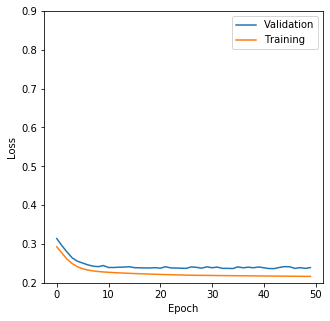

In [25]:
fig, ax = plt.subplots(1, figsize = (5,5))
ax.plot(vldtn_losses, label = 'Validation')
ax.plot(losses, label = 'Training')
ax.legend();
ax.set(xlabel = 'Epoch', ylabel = 'Loss', ylim = [0.2,0.9]);

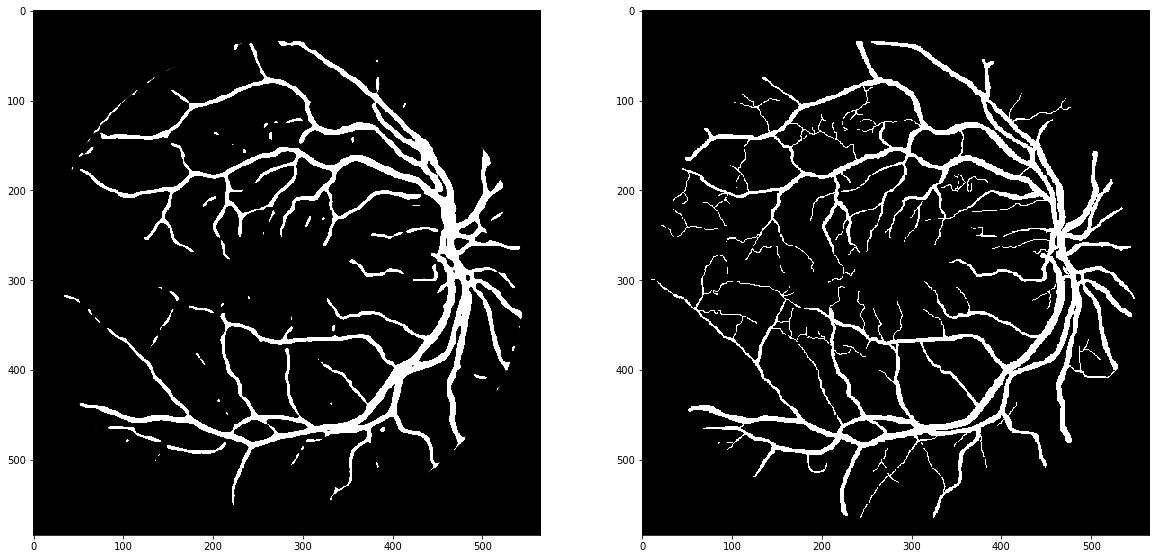

In [26]:
ind = 0
fig, ax = plt.subplots(1,2, figsize = (20,10))
with torch.no_grad():
    predicted = torch.sigmoid(output[ind,0,:,:]).cpu().detach().numpy()
    screen_numpy = screen[ind,0,:,:].cpu().detach().numpy()
    mn = 0.5
    predicted[screen_numpy < 0.5] = 0
    predicted[predicted > mn] = 1
    t_array = target[ind,0,:,:].cpu().detach().numpy()
    ax[0].imshow(predicted, cmap = 'gray')
    ax[1].imshow(t_array, cmap = 'gray')

In [27]:
torch.save(model, str(BaseFolder / 'Model680_Intrpld2_dice_1bs_SGD0p1_50Epochs_then_ModelOrg_dice_1bs_SGD1e3_5Epochs_well.pth'))

In [ ]:
! sudo shutdown -h now

C:\ProgramData\Anaconda3\envs\torch\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type UNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\envs\torch\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\envs\torch\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\envs\torch\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__nam

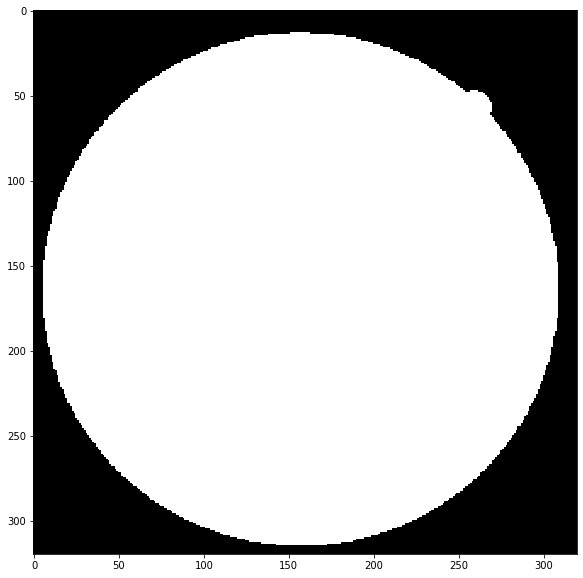

In [23]:
plt.figure(figsize=(10,10))
if batch_size>1: 
#     plt.imshow(output[0].squeeze().cpu().detach().numpy(), cmap='gray')
    plt.imshow(screen[0].squeeze().cpu().detach().numpy(), cmap='gray')
else: 
    plt.imshow(output[0].squeeze().cpu().detach().numpy(), cmap='gray')
# plt.imshow(screen.squeeze().cpu().detach().numpy(), cmap='gray')

In [40]:
torch.save(model, str(BaseFolder / 'Model320NoIntrpl_dice_200Epochs.pth'))

/opt/anaconda3/envs/torchgpu/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type UNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [23]:
# torch.save(model, str(BaseFolder / 'Model320Bilinear.pth'))

In [29]:
x_test_dir = DataFolder/'test'/'images'

In [41]:
test_dataset = Dataset(
    x_train_dir, 
    screen_train_dir,
    classes=['yes'],
)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


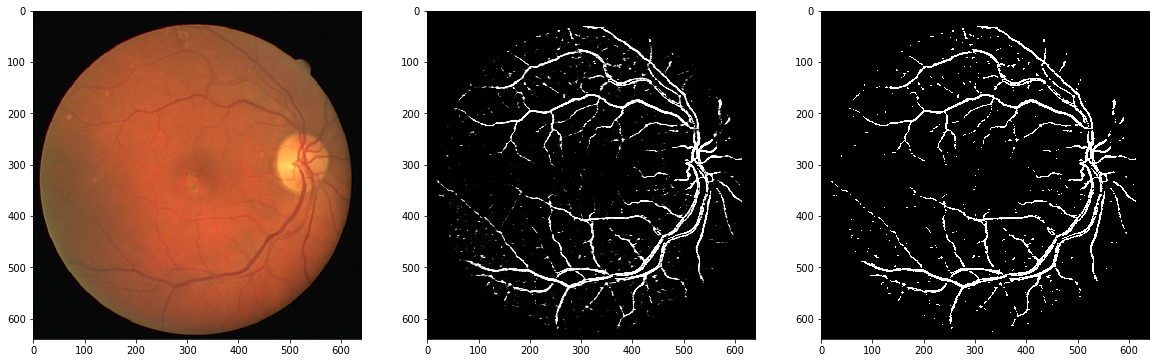

In [42]:
ind = 4
with torch.no_grad():
    fig, ax = plt.subplots(1,3, figsize = (20,8))

    x = test_dataset[ind][0].unsqueeze(0)
    o = model(x.cuda())
    original_image = x.cpu().detach().numpy()
    original_image = np.transpose(original_image[0], axes = [1,2,0])
    original_image = original_image * std + mean
    output_image = o.cpu().detach().numpy() 
    output_image = np.squeeze(output_image)
    output_image = 1/(1 + np.exp(-output_image)) 
    # mn = np.mean(output_image)*5
    mn = 0.5
    output_image_thresh = np.copy(output_image)
    output_image_thresh[output_image<mn] = 0
    output_image_thresh[output_image>mn] = 1
    ax[0].imshow(original_image)
    ax[1].imshow(output_image, cmap = 'gray')
    ax[2].imshow(output_image_thresh, cmap = 'gray')

TypeError: Invalid shape (2, 480, 480) for image data

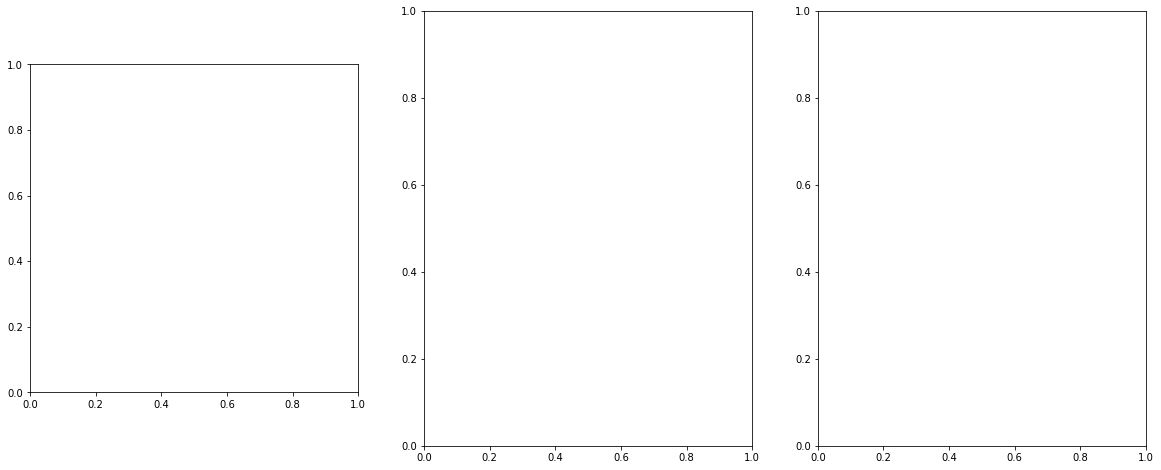

In [131]:
# if training over one bs = 1
fig, ax = plt.subplots(1,3, figsize = (20,8))
# x = augmented_dataset[0][0].unsqueeze(0)
# o = model(x.cuda())  
# tmp2 = o.cpu().detach().numpy() * (-1)
tmp2 = output.cpu().detach().numpy() 
tmp = np.copy(tmp2)
tmp3 = np.copy(tmp2)
mn = np.mean(tmp)*0.05
tmp3[tmp<mn] = 0
tmp3[tmp>mn] = 1
ax[0].imshow(np.squeeze(tmp3), cmap = 'binary_r')

target_numpy = target.cpu().detach().numpy()
ax[1].imshow(np.squeeze(target_numpy), cmap = 'binary_r')
ax[2].imshow(np.squeeze(tmp2), cmap = 'binary_r')

## Not figuring out things with loss functions

In [605]:
def WCE(output, target, weight = torch.tensor(1)):
    """My custom WEIGHTED Cross Entropy loss function. It first runs the output through a Sigmoid, then computes the
    cross entropy. Weight is in range [0,inf]. To decrease the number of false negatives, use a large weight. 
    To decrease the number flase positives, set to small. 
    """
    output_clone = output.detach().clone()
    eps=torch.tensor(1e-21)
    return -(weight * target * F.logsigmoid(output_clone) + (1-target) * F.logsigmoid(1 - output_clone)).sum()
    # return -(weight * target * logSigmoid(output) + (1-target) * logSigmoid(1 - output)).sum()

In [604]:
def focal_loss(output, target, weight = torch.tensor(1)):
    """My custom Focal loss function. It first runs the output through a Sigmoid, then computes the
    cross entropy. Weight is in range [0,1]. To decrease the number of false negatives, use a large weight. 
    To decrease the number flase positives, set to small. 
    See Lar's Blog on losses. 
    """
    

In [603]:
def BCE(output, target, weight = torch.tensor(1)):
    """My custom Balanced Cross Entropy loss function. It first runs the output through a Sigmoid, then computes the
    cross entropy. Weight is in range [0,1]. To decrease the number of false negatives, use a large weight. 
    To decrease the number flase positives, set to small. 
    It is not like BCE binary cross entropy:
    https://discuss.pytorch.org/t/weights-in-bcewithlogitsloss/27452/10
    https://discuss.pytorch.org/t/confusing-error-using-bcewithlogitsloss-with-weighted-loss/42435
    """
    eps=0
    output_clone = output.detach().clone()
    # output_clone = Sigmoid(output_clone)
    return -(weight * target * F.logsigmoid(output_clone + eps) +  (1-weight) * (1-target) * F.logsigmoid(1 - output_clone + eps)).sum()

In [632]:
weight = torch.tensor(1)
output = 1* torch.randn(3)
target = torch.empty(3).random_(2)
criterion = nn.BCEWithLogitsLoss(weight=weight, reduction='sum')
print(criterion(output, target))
print(WCE(output, target, weight = weight))
print(binary_cross_entropy_with_logits(output, target, weight=weight, reduction='sum'))
print(output, target)

tensor(2.0488)
tensor(1.6132)
tensor(2.0488)
tensor([-0.9652, -0.2209, -1.6723]) tensor([1., 0., 0.])


In [376]:
from torch.nn.functional import binary_cross_entropy_with_logits

In [ ]:
binary_cross_entropy_with_logits()

tensor(1.0091)